# Randomization Unit

This notebook will check the issues of randomizing by user but evaluating by sessions

In [1]:
from __future__ import annotations
from IPython import get_ipython
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
get_ipython().run_line_magic('matplotlib', 'inline')

import scipy.stats as stats
from sklearn.metrics import auc

In [2]:
def assign_random_variant(df, users, variant_col, random_seed=42, num_samples=None, replace=True):
    np.random.seed(random_seed)
    unique_users = pd.DataFrame({"user_id":users, 
                                 variant_col:np.random.choice(['control', 'treatment'], size=len(users), p=[0.5, 0.5])})
    if num_samples:
        unique_users = unique_users.sample(num_samples, replace=replace)
    df = df.merge(unique_users, how="left", on="user_id")
    return df

In [3]:
def t_test_mean_diff(df, variant_col, value_col, variant1="treatment", variant2="control", 
                     alpha=0.05, alternative='two-sided'):
    control_values = df[df[variant_col] == variant1][value_col]
    treatment_values = df[df[variant_col] == variant2][value_col]
    t_statistic, p_value = stats.ttest_ind(control_values, treatment_values, alternative=alternative)
    
    # Determine whether to reject the null hypothesis
    reject_null = p_value < alpha
    
    return t_statistic, p_value, reject_null

# Define the function to apply the z-test to multiple dataframes
def run_test_mean_diff(df, variant_col, value_col, number_of_tests=100, 
                                num_samples=None, alternative="two-sided", effect=0, alpha=0.05):
    # Initialize an empty DataFrame to store the results
    results_df = pd.DataFrame(columns=['test_number', 
                                       't_score', 'p_value', 'reject_null'])
    if variant_col in df.columns:
        df.drop(variant_col, inplace=True, axis=1)
    
    users = df["user_id"].unique()
    
    # Iterate over pairs of dataframes
    for i in range(number_of_tests):
        if i % 100 == 0:
            print(i)
        random_df = assign_random_variant(df, users=users, variant_col=variant_col, random_seed=i, num_samples=num_samples)
        random_df[value_col] = np.where(random_df[variant_col]=="treatment", 
                                        random_df[value_col]*(1+effect), 
                                        random_df[value_col])

        # Apply the t-test to the pair of dataframes
        t_score, t_p_value, t_reject_null = t_test_mean_diff(random_df, variant_col=variant_col, alpha=alpha,
                                                             value_col=value_col, alternative=alternative)
        
        # Add the results to the DataFrame
        this_results = pd.DataFrame({'test_number': i,
                                        't_score': t_score,
                                        'p_value': t_p_value,
                                        'reject_null': t_reject_null, },
                                   index=[0])
        results_df = pd.concat([results_df, this_results])
    
    # Return the results DataFrame
    return results_df

In [4]:
base_path = os.path.abspath('')

events_df = pd.read_csv(f"{base_path}/Data/events_complete.csv")
events_df = events_df[(events_df["date"]).between("2020-01-01", "2020-02-31")]

events_df.replace({True: 1, False: 0}, inplace=True)
events_df.head()

,event_time,product_id,category_id,category_code,brand,price,user_id,user_session,time,date,sales,event_type_cart,event_type_purchase,event_type_remove_from_cart,event_type_view
12271406,2020-01-01 00:00:00 UTC,5809910,1602943681873052386,NaN,grattol,5.24,595414620,4adb70bb-edbd-4981-b60f-a05bfd32683a,2020-01-01 00:00:00+00:00,2020-01-01,0.0,0.0,0.0,0.0,1.0
12271407,2020-01-01 00:00:09 UTC,5812943,1487580012121948301,NaN,kinetics,3.97,595414640,c8c5205d-be43-4f1d-aa56-4828b8151c8a,2020-01-01 00:00:09+00:00,2020-01-01,0.0,0.0,0.0,0.0,1.0
12271408,2020-01-01 00:00:19 UTC,5798924,1783999068867920626,NaN,zinger,3.97,595412617,46a5010f-bd69-4fbe-a00d-bb17aa7b46f3,2020-01-01 00:00:19+00:00,2020-01-01,0.0,0.0,0.0,0.0,1.0
12271409,2020-01-01 00:00:24 UTC,5793052,1487580005754995573,NaN,NaN,4.92,420652863,546f6af3-a517-4752-a98b-80c4c5860711,2020-01-01 00:00:24+00:00,2020-01-01,0.0,0.0,0.0,0.0,1.0
12271410,2020-01-01 00:00:25 UTC,5899926,2115334439910245200,NaN,NaN,3.92,484071203,cff70ddf-529e-4b0c-a4fc-f43a749c0acb,2020-01-01 00:00:25+00:00,2020-01-01,0.0,0.0,0.0,0.0,1.0


Plot the distributions of events/sessions per user and the convertions (has_purchase) vs that

In [5]:
agg_ussers = (
    events_df
    .groupby("user_id")
    .agg({
        "product_id":           "count",
        "user_session":         "nunique",
        "event_type_purchase":  "sum",
        "sales":                "sum",
    })
).reset_index()

agg_ussers.columns = ["user_id", "events", "sessions", "n_purchases", "total_sales"]
agg_ussers

,user_id,events,sessions,n_purchases,total_sales
0,465496,3,2,0.0,0.0
1,2038666,1,1,0.0,0.0
2,3571443,2,1,0.0,0.0
3,4230352,1,1,0.0,0.0
4,4661182,20,6,0.0,0.0
...,...,...,...,...,...
737088,622090016,2,2,0.0,0.0
737089,622090043,3,1,0.0,0.0
737090,622090052,2,2,0.0,0.0
737091,622090098,1,1,0.0,0.0


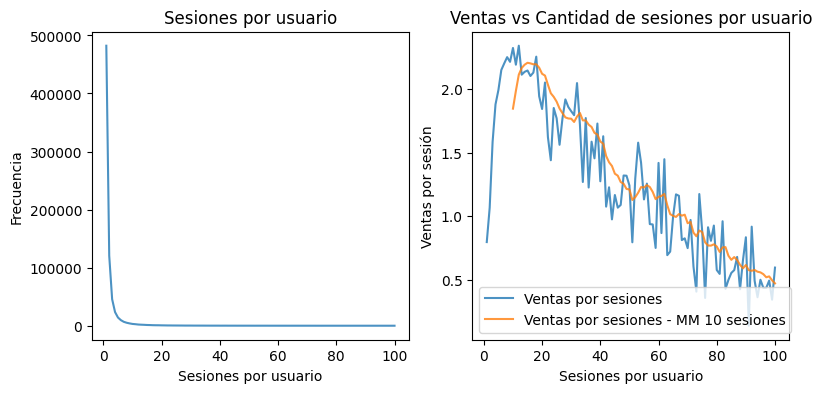

In [16]:
sessions_per_user = (
    agg_ussers
    .groupby("sessions")
    .agg({
        "user_id":      "count",
        "n_purchases":  "sum",
        "total_sales":  "sum",
    })
).reset_index()
sessions_per_user.columns = ["sessions", "users", "n_purchases", "total_sales"]
sessions_per_user["purchases_per_user"] = sessions_per_user["n_purchases"] / sessions_per_user["users"]
sessions_per_user["session_conversions"] = sessions_per_user["purchases_per_user"] / sessions_per_user["sessions"]
sessions_per_user['session_conversions_ma'] = sessions_per_user['session_conversions'].rolling(10).mean()

sessions_per_user["sales_per_user"] = sessions_per_user["total_sales"] / sessions_per_user["users"]
sessions_per_user["session_sales"] = sessions_per_user["sales_per_user"] / sessions_per_user["sessions"]
sessions_per_user['session_sales_ma'] = sessions_per_user['session_sales'].rolling(10).mean()

fig, ax = plt.subplots(1,2, figsize=(9, 4))
sns.lineplot(sessions_per_user[sessions_per_user["sessions"].between(1,100)], x="sessions", y="users", ax=ax[0], alpha=0.8)
sns.lineplot(sessions_per_user[sessions_per_user["sessions"].between(1,100)], x="sessions", y="session_sales", ax=ax[1], alpha=0.8, label="Ventas por sesiones")
sns.lineplot(sessions_per_user[sessions_per_user["sessions"].between(1,100)], x="sessions", y="session_sales_ma", ax=ax[1], alpha=0.8, label="Ventas por sesiones - MM 10 sesiones")

ax[0].set_title("Sesiones por usuario")
ax[0].set_xlabel('Sesiones por usuario')
ax[0].set_ylabel('Frecuencia')
ax[1].set_title("Ventas vs Cantidad de sesiones por usuario")
ax[1].set_xlabel('Sesiones por usuario')
ax[1].set_ylabel('Ventas por sesión')
ax[1].legend()

## p-values

In [7]:
# Transform to user-based data
sessions_df = events_df.groupby(["user_session", "user_id"]).agg(
    {
        "user_id":                      ['size'],
        "sales":                        ['sum'],
        "event_type_view":              ["sum", "max"],
        "event_type_cart":              ["sum", "max"],
        "event_type_remove_from_cart":  ["sum", "max"],
        "event_type_purchase":          ["sum", "max"],
        "date":                         ["min", "max"]
    }
)
sessions_df.columns = ['_'.join(col).strip() for col in sessions_df.columns.values]
sessions_df = sessions_df.rename(columns={
    'user_id_size': 'num_events', 'sales_sum': 'total_sales', 
    'event_type_view_sum': 'total_views', 'event_type_view_max': 'has_view',
    'event_type_cart_sum': 'total_cart', 'event_type_cart_max': 'has_cart',
    'event_type_remove_from_cart_sum': 'total_remove_from_cart', 'event_type_remove_from_cart_max': 'has_remove_from_cart',
    'event_type_purchase_sum': 'total_purchases', 'event_type_purchase_max': 'has_purchases',
}).reset_index()

0
100
200
300
400
auc p-value: 0.5155093150651444


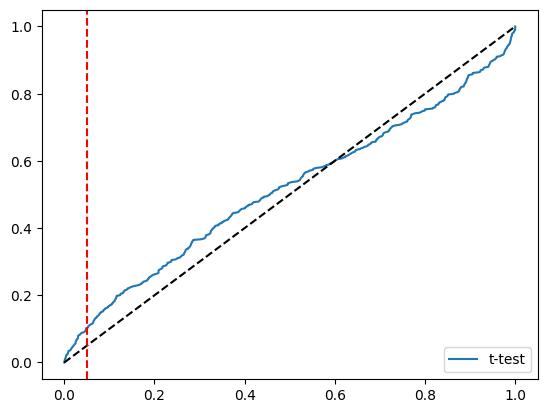

In [8]:
iterations = 500
samples = 2000

p_values_AA = run_test_mean_diff(sessions_df, variant_col="variant", value_col="total_sales", 
                                          number_of_tests=iterations, num_samples=samples, alternative="greater")
p_values_AA = p_values_AA.reset_index(drop=True)

auc_value = auc(sorted(p_values_AA["p_value"]), np.linspace(0, 1, iterations))
print(f"auc p-value: {auc_value}")

fig, ax = plt.subplots()
ax.plot(sorted(p_values_AA["p_value"]), np.linspace(0, 1, iterations), label="t-test")
ax.legend()
ax.plot([0,1],[0,1], '--k')
ax.axvline(0.05, ls='--', color="red")

0
100
200
300
400
auc p-value: 0.5902738173081538


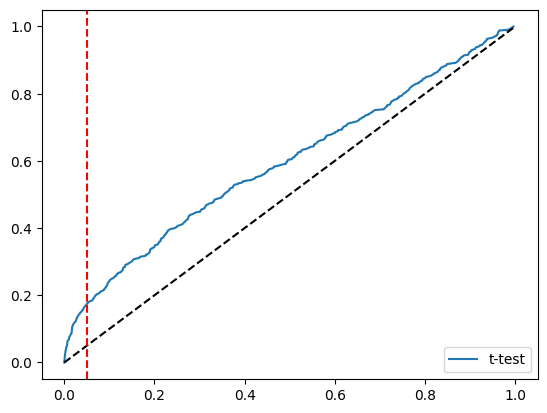

In [10]:
iterations = 500
samples = 20000

p_values_AA = run_test_mean_diff(sessions_df, variant_col="variant", value_col="total_sales", 
                                          number_of_tests=iterations, num_samples=samples, alternative="two-sided")
p_values_AA = p_values_AA.reset_index(drop=True)

auc p-value: 0.5902738173081538


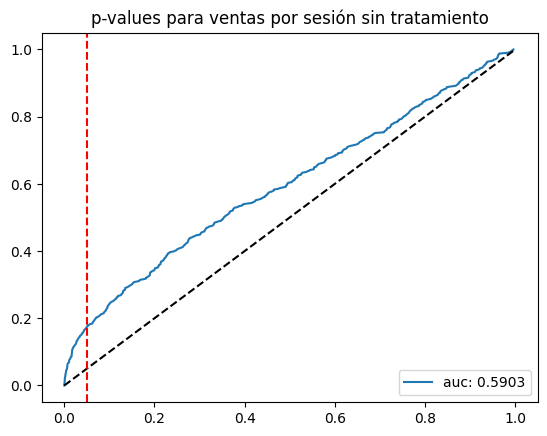

In [20]:
auc_value = auc(sorted(p_values_AA["p_value"]), np.linspace(0, 1, iterations))
print(f"auc p-value: {auc_value}")

fig, ax = plt.subplots()
ax.plot(sorted(p_values_AA["p_value"]), np.linspace(0, 1, iterations), label=f"auc: {round(auc_value,4)}")
ax.legend()
ax.plot([0,1],[0,1], '--k')
ax.set_title("p-values para ventas por sesión sin tratamiento")
ax.axvline(0.05, ls='--', color="red")

We can observe that the p-values are not uniformely distributed under the null, with ~15% false positives expected if we use the sessions